In [1]:
from torchvision import datasets, transforms, models
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy
import torchvision.transforms as T
import torch

from PIL import Image
import requests

import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn

In [2]:
from fastai.vision.all import *
from fastai.distributed import *
from fastai.metrics import error_rate
from fastai.callback.tracker import SaveModelCallback

In [3]:
from models.utils.joiner2 import Joiner
from models.utils.losses import *
from models.utils.datasets import *
from models.utils.metrics import *

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
H = 320
W= 320

transform = T.Compose([
T.Resize((H,W)),
T.ToTensor(),
T.Normalize([0.485, 0.456, 0.406], [0.485, 0.456, 0.406])
])

In [26]:
ds = ImagenetRotation(path='./data', transforms=transform, size=50000)

In [27]:
# training_dataset = ImagenetRotation(path='./data', transforms=transform, size=40000)
# validation_dataset = ImagenetRotation(path='./data', transforms=transform, size=8000)

# train_dl = DataLoader(training_dataset,bs=10).to(device)
# valid_dl = DataLoader(validation_dataset,bs=10).to(device)

train_size = 40000
test_size = 10000
remainder = 0

train, valid, _ = torch.utils.data.random_split(ds, [train_size, test_size, remainder])

In [28]:
train_dl = DataLoader(train,bs=10)
valid_dl = DataLoader(valid,bs=10)
dld = ImageDataLoaders(train_dl, valid_dl, device='cuda')

In [34]:
ds[0]

(tensor([[[-0.9353, -0.9272, -0.9191,  ..., -0.8545, -0.8464, -0.8464],
          [-0.9353, -0.9272, -0.9191,  ..., -0.8383, -0.8383, -0.8383],
          [-0.9353, -0.9272, -0.9191,  ..., -0.8383, -0.8383, -0.8383],
          ...,
          [-0.8868, -0.9030, -0.9111,  ..., -0.9757, -0.9677, -0.9677],
          [-0.8868, -0.9030, -0.9111,  ..., -0.9757, -0.9677, -0.9677],
          [-0.8868, -0.8949, -0.9030,  ..., -0.9757, -0.9677, -0.9677]],
 
         [[-0.9312, -0.9226, -0.9140,  ..., -0.8452, -0.8366, -0.8366],
          [-0.9312, -0.9226, -0.9140,  ..., -0.8280, -0.8280, -0.8280],
          [-0.9312, -0.9226, -0.9140,  ..., -0.8280, -0.8280, -0.8280],
          ...,
          [-0.8796, -0.8968, -0.9054,  ..., -0.9742, -0.9656, -0.9656],
          [-0.8796, -0.8968, -0.9054,  ..., -0.9742, -0.9656, -0.9656],
          [-0.8796, -0.8882, -0.8968,  ..., -0.9742, -0.9656, -0.9656]],
 
         [[-0.9227, -0.9131, -0.9034,  ..., -0.8261, -0.8165, -0.8165],
          [-0.9227, -0.9131,

In [30]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [31]:
dataiter = iter(train_dl)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(10):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])

AttributeError: 'generator' object has no attribute 'next'

In [9]:
model = Joiner(num_encoder_layers = 4, nhead=1, backbone = True, num_classes = 4, bypass=False, mask=None, pos_enc = "sin", batch_size=10, hidden_dim=256, image_h=320, image_w=320, grid_l=4, penalty_factor="1", alpha=1)

In [13]:
model = model.to(device)

In [10]:
#TESTING MODEL ON A SINGLE IMAGE

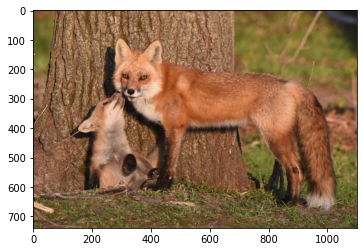

In [10]:
url = 'https://ogden_images.s3.amazonaws.com/www.timesrepublican.com/images/2019/05/02231710/Fox-WEB-1100x739.jpg'

im = Image.open(requests.get(url, stream=True).raw)
plt.plot()
plt.imshow(im)

In [11]:
img = transform(im).unsqueeze(0)
print("Input shape:", img.shape)

Input shape: torch.Size([1, 3, 320, 320])


In [14]:
outputs, sattn, pattn = model(img.to(device))

In [ ]:
print("Output shape:", outputs.shape)
#print("Feature Map shape:", f_map.shape)
print("Attention Maps shape:", sattn.shape)
#print("Encoder output shape:", att.shape)
#print("Positional Encoding shape:", pos.shape)

In [ ]:
#Training Model

In [ ]:
criterion = CriticLoss()

In [36]:
learn = Learner(dld, model, loss_func=CriticLoss(), metrics=[Accuracy])

SuggestedLRs(lr_min=4.78630090583465e-07, lr_steep=1.5848931980144698e-06)

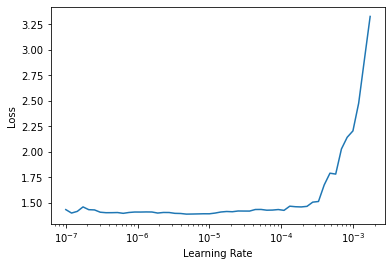

In [40]:
learn.lr_find()

In [41]:
learn.fit_one_cycle(5,5e-7)

epoch,train_loss,valid_loss,Accuracy,time
0,1.353359,1.380927,0.301100,19:52
1,1.319984,1.384906,0.308100,19:52
2,1.250150,1.396263,0.303300,19:53
3,1.167478,1.401043,0.304900,19:52
4,1.277850,1.398227,0.302900,19:52


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


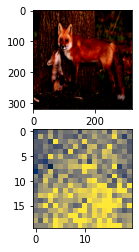

In [46]:
pix_h = 14
pix_w = 14
outputs, sattn2, pattn2 = model(img.to(device))
threshold = torch.sum(sattn2[0,pix_h,pix_w,...])/300#6.3665e-38
plt.subplot(221)
plt.imshow(img[0].cpu().permute(1, 2, 0))
plt.subplot(223)
plt.imshow(sattn2[0,pix_h,pix_w,...].cpu().detach().numpy(),cmap='cividis',vmax=threshold)

In [36]:
torch.save(model.state_dict(),'test/RandomNoise_Encoder_no_bypass_CIFAR10.pth')

In [47]:
outputs

tensor([[ 0.2073, -0.7035, -1.0990, -1.2295]], device='cuda:0',
       grad_fn=<AddmmBackward>)